#aygazgoruntuisleme




In [ ]:
#This project was created for GlobalAIHub.
#Its main purpose is to create a CNN (Convolutional Neural Network) model by extracting certain animal classes
#from the given image pool and build a *Classification* algorithm.

## 1-Installing the necessary **libraries**

In [1]:
import os
import numpy as np
import cv2
import kagglehub
import shutil
import random

import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from PIL import Image, ImageEnhance, ImageOps


##2-Obtaining the data set and preprocces

### 2.1 - Dataset filter method

In [2]:
#Dataset filter method

def create_filtered_dataset(source_dir, target_dir, selected_animals, max_images_per_animal):

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for animal in selected_animals:
        source_animal_dir = os.path.join(source_dir, animal)
        target_animal_dir = os.path.join(target_dir, animal)

        if not os.path.exists(source_animal_dir):
            print(f"folder not found: {source_animal_dir}")
            continue

        if not os.path.exists(target_animal_dir):
            os.makedirs(target_animal_dir)

        # Take all pic in folder
        all_images = [f for f in os.listdir(source_animal_dir) if os.path.isfile(os.path.join(source_animal_dir, f))]

        # Shuffle the images and select the specified amount
        selected_images = random.sample(all_images, min(len(all_images), max_images_per_animal))

        for image in selected_images:
            source_image_path = os.path.join(source_animal_dir, image)
            target_image_path = os.path.join(target_animal_dir, image)

            shutil.copy(source_image_path, target_image_path)



    print("Copy Succesfull!")

###2.2 - **Download** the dataset from "Kaggle"

In [3]:
#Download the dataset from "Kaggle"

rrebirrth_animals_with_attributes_2_path = kagglehub.dataset_download('rrebirrth/animals-with-attributes-2')

print('Data source import complete.')

# Initialize the dictionary to hold paths for each animal
image_paths = {}

#Base directory for your dataset
base_path = "/root/.cache/kagglehub/datasets/rrebirrth/animals-with-attributes-2/versions/1/Animals_with_Attributes2/JPEGImages/"

#Target directory for new dataset
target_path = "filteredImages"

#List of animals to search for
selected_animals = ["collie", "dolphin", "elephant", "fox", "moose", "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]

#How many images to get from each class
images_per_class = 650

#Call methods for filter
create_filtered_dataset(base_path, target_path, selected_animals, images_per_class)

100%|██████████| 13.0G/13.0G [02:43<00:00, 84.9MB/s]

Extracting files...


Data source import complete.
Copy Succesfull!


###2.3.1 - Resizing and Normalization Method




In [4]:
#Resize and Normalization
def load_and_process_images(data_dir, image_size=(128, 128)):
    images = []
    labels = []
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                img = cv2.imread(file_path)
                if img is not None:
                    img_resized = cv2.resize(img, image_size)
                    img_normalized = img_resized / 255.0
                    images.append(img_normalized)
                    labels.append(class_name)
    return np.array(images), np.array(labels)

###2.3.2- Resizing and Normalization

In [5]:
data_dir = target_path

X, y = load_and_process_images(data_dir)

print(f"dataset size: {X.shape}")

dataset size: (6500, 128, 128, 3)


###2.4 - Train-Test Split


In [9]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split the dataset(%70 for Train, %30 for Test)
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.3, random_state=40)
print(f"Traind data size: {X_train.shape}, Test data size: {X_test.shape}")

Traind data size: (5961, 128, 128, 3), Test data size: (2556, 128, 128, 3)


##3- Augmentation

In [10]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

##4-Create the CNN Model

In [11]:
# model
model = Sequential([
    Input(shape=(128, 128, 3)),  # Burada Input kullanılıyor
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])


# compile
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)



# traing and test generator
train_generator = datagen.flow(X_train, y_train, batch_size=32)
validation_generator = datagen.flow(X_test, y_test, batch_size=32)

# steps_per_epoch ve validation_steps
steps_per_epoch = len(X_train) // 32
validation_steps = len(X_test) // 32

# train the cnn model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


186/186 ━━━━━━━━━━━━━━━━━━━━ 185s 972ms/step - accuracy: 0.2300 - loss: 3.4377 - val_accuracy: 0.4066 - val_loss: 1.7042
Epoch 2/20
  1/186 ━━━━━━━━━━━━━━━━━━━━ 2:11 711ms/step - accuracy: 0.3750 - loss: 1.7693

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.3750 - loss: 1.7693 - val_accuracy: 0.2143 - val_loss: 2.0904
Epoch 3/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 176s 942ms/step - accuracy: 0.4476 - loss: 1.5944 - val_accuracy: 0.5012 - val_loss: 1.4632
Epoch 4/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.6562 - loss: 1.2819 - val_accuracy: 0.5000 - val_loss: 1.6064
Epoch 5/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 182s 926ms/step - accuracy: 0.5003 - loss: 1.4666 - val_accuracy: 0.5237 - val_loss: 1.4236
Epoch 6/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step - accuracy: 0.5312 - loss: 1.3298 - val_accuracy: 0.6071 - val_loss: 1.2782
Epoch 7/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 176s 938ms/step - accuracy: 0.5321 - loss: 1.3875 - val_accuracy: 0.5427 - val_loss: 1.3651
Epoch 8/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 600us/step - accuracy: 0.5938 - loss: 1.3906 - val_accuracy: 0.6071 - val_loss: 1.0819
Epoch 9/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 176s 936ms/step - accuracy: 0.5353 - loss: 1.3539 - val

In [29]:
#Model Test
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Doğruluğu: {test_accuracy * 100:.2f}%")

80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 169ms/step - accuracy: 0.6159 - loss: 1.1502
Test Doğruluğu: 60.84%


##4.2 - Model Test and Data Visualise

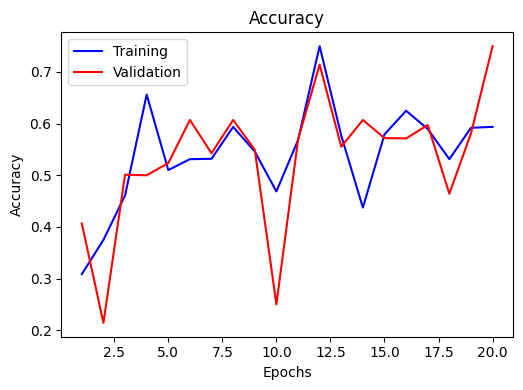

In [12]:
# Extract training and validation values and determine epochs
acc, val_acc, loss, val_loss, epochs = history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'], range(1, len(history.history['accuracy']) + 1)

# Training and verification accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1); plt.plot(epochs, acc, 'b-', label='Training'); plt.plot(epochs, val_acc, 'r-', label='Validation'); plt.title('Accuracy'); plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend()

plt.tight_layout(); plt.show()


##5.1 - Manipulate Methods

In [22]:
## Manipulate Methods.
def get_manipulated_images(images):
    manipulated_images = []
    for img in images:
        manipulated = cv2.convertScaleAbs(img, alpha=0.8, beta=30)
        manipulated_images.append(manipulated)
    return np.array(manipulated_images)


##5.2 - Manipulate Images

In [24]:
X_test_manipulated = get_manipulated_images(X_test)
manipulated_loss, manipulated_accuracy = model.evaluate(X_test_manipulated, y_test)
print(f"Model accuracy on manipulated data set:{manipulated_accuracy * 100:.2f}")

80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - accuracy: 0.0925 - loss: 246.1040
Model accuracy on manipulated data set:9.70


##6.1 - Gray World Algorithm

In [26]:
def apply_gray_world(image):
    avg_b, avg_g, avg_r = cv2.mean(image)[:3]
    gray_value = (avg_b + avg_g + avg_r) / 3
    scaling_factors = np.array([gray_value / avg_b, gray_value / avg_g, gray_value / avg_r])
    corrected_image = image * scaling_factors  # Her kanal için ayrı ölçekleme
    corrected_image = np.clip(corrected_image, 0, 255).astype(np.uint8)
    return corrected_image


In [27]:
X_test_corrected = np.array([apply_gray_world(img) for img in X_test_manipulated])

corrected_loss, corrected_accuracy = model.evaluate(X_test_corrected, y_test)
print(f"Test Accuracy with Color Constancy Applied: {corrected_accuracy * 100:.2f}%")

80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - accuracy: 0.0925 - loss: 237.9681
Test Accuracy with Color Constancy Applied: 9.70%


#7 - Results

In [30]:
print("Results:")
print(f"Original Test Set Accuracy: {test_accuracy * 100:.2f}%")
print(f"Manipulated Test Set Accuracy: {manipulated_accuracy * 100:.2f}%")
print(f"Test Set Accuracy with Color Constancy Applied: {corrected_accuracy * 100:.2f}%")

Results:
Original Test Set Accuracy: 60.84%
Manipulated Test Set Accuracy: 9.70%
Test Set Accuracy with Color Constancy Applied: 9.70%
